In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn

In [37]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [38]:
import torch.distributions as dist

In [39]:
μ_α = dist.Normal(0.0, 2.0)
σ_α =dist.HalfNormal(1.0)
μ_β = dist.Normal(0.0, 3.0)
σ_β = dist.HalfNormal(1.0) 

n_tasks = 11

In [40]:
μ_α_samples = μ_α.sample((n_tasks,))
σ_α_samples = σ_α.sample((n_tasks,))
μ_β_samples = μ_β.sample((n_tasks,))
σ_β_samples = σ_β.sample((n_tasks,))


In [41]:
α = dist.Normal(μ_α_samples, σ_α_samples).sample()
β = dist.Normal(μ_β_samples, σ_β_samples).sample()

σ = dist.HalfNormal(5.0).sample((n_tasks,))

In [56]:
x_lin = torch.linspace(-1, 1, 100)

true_fs = []
ys = []

for i in range(n_tasks):
    true_fs.append(α[i] + β[i] * x_lin)

# Add noise
for i in range(n_tasks):
    ys.append(dist.Normal(true_fs[i], σ[i]).sample())

# Normalize both x and y for all tasks
true_fs_norm = []
ys_norm = []
x_means_task = []
x_stds_task = []
y_means_task = []
y_stds_task = []


for i in range(n_tasks):
    x_means_task.append(x_lin.mean())
    x_stds_task.append(x_lin.std())
    y_means_task.append(ys[i].mean())
    y_stds_task.append(ys[i].std())
    ys_norm.append((ys[i] - ys[i].mean()) / ys[i].std())
    true_fs_norm.append((true_fs[i] - true_fs[i].mean()) / true_fs[i].std())


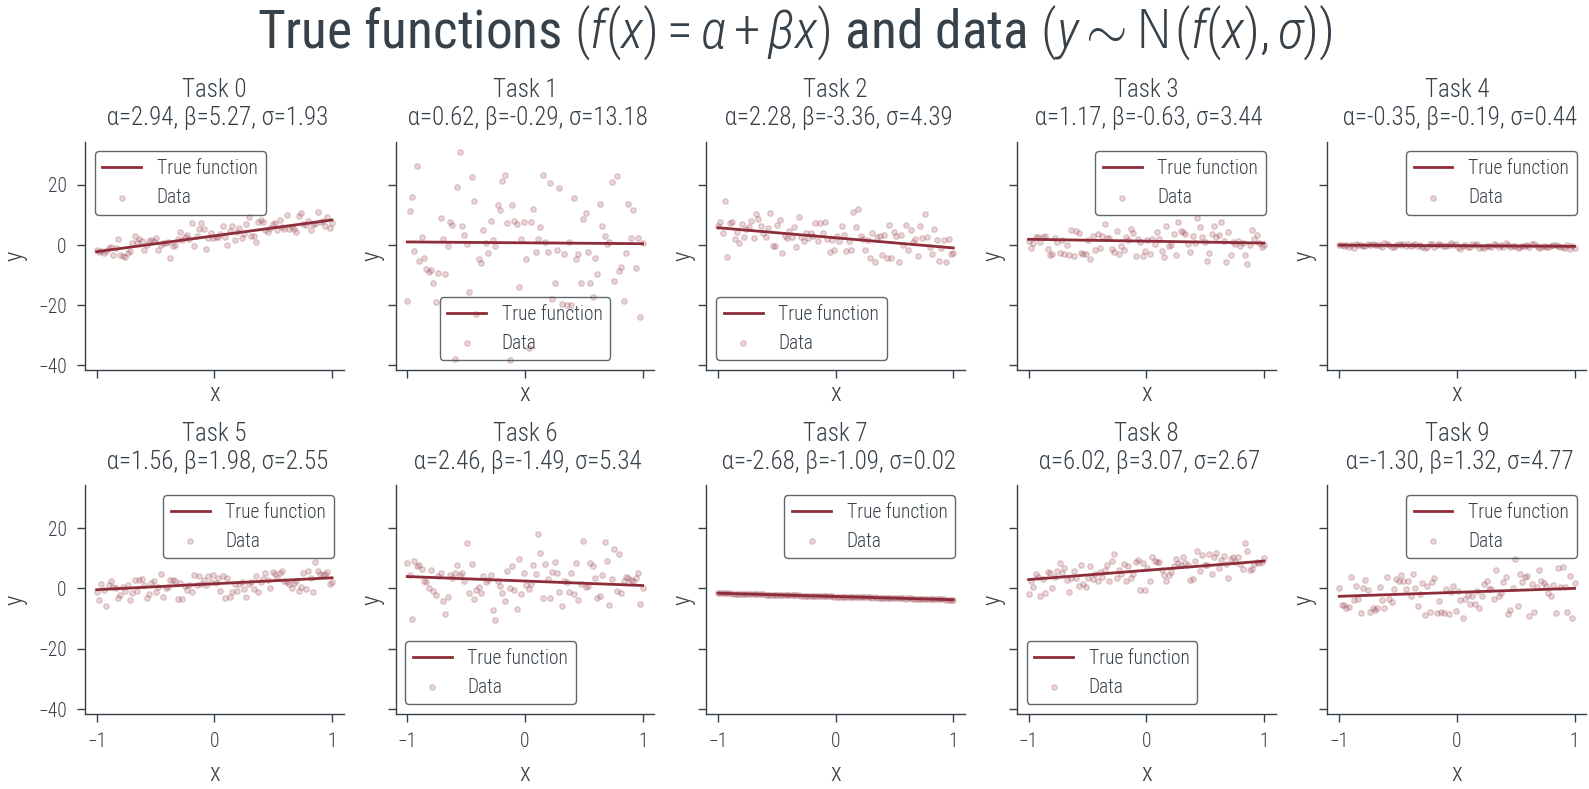

In [57]:
# Plot the `n_tasks` functions with noise and the true functions in grid 
# of 2 x 5

fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.plot(x_lin, true_fs[i], label='True function')
    ax.scatter(x_lin, ys[i], label='Data', s=4, alpha=0.2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # Print the parameters in the title
    ax.set_title(f'Task {i}\n α={α[i]:.2f}, β={β[i]:.2f}, σ={σ[i]:.2f}')
    ax.legend()
plt.suptitle(r'True functions $(f(x) = \alpha + \beta x)$ and data $(y \sim \mathcal{N}(f(x), \sigma))$')
plt.savefig("../diagrams/metalearning/true.pdf", bbox_inches="tight")

Text(0.5, 0.98, 'True functions $(f(x) = \\alpha + \\beta x)$ and data $(y \\sim \\mathcal{N}(f(x), \\sigma))$')

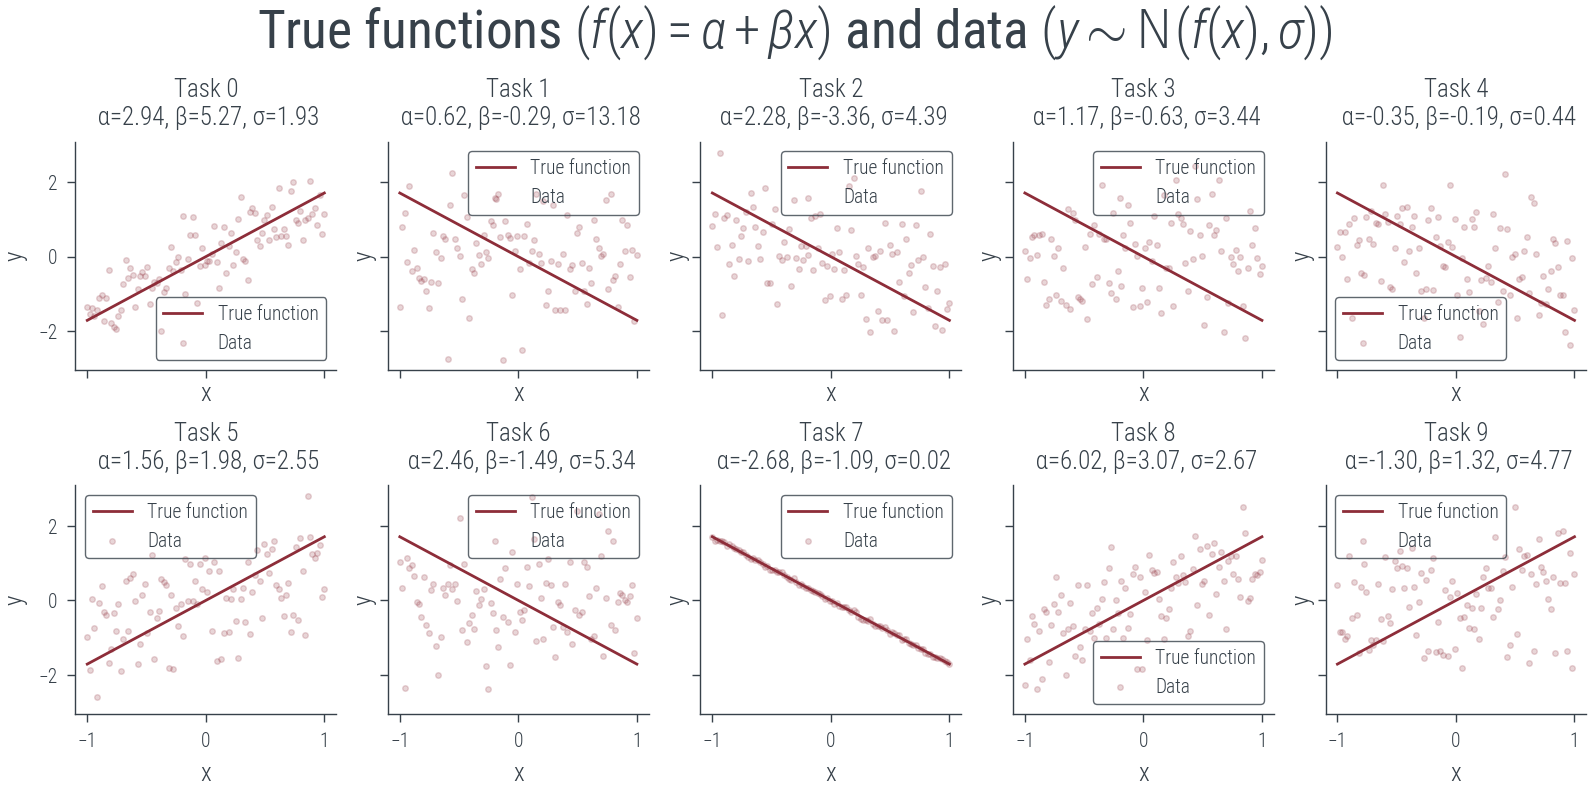

In [58]:
# Plot the normalized functions and data in grid of 2 x 5
fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.plot(x_lin, true_fs_norm[i], label='True function')
    ax.scatter(x_lin, ys_norm[i], label='Data', s=4, alpha=0.2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Task {i}\n α={α[i]:.2f}, β={β[i]:.2f}, σ={σ[i]:.2f}')
    ax.legend()
plt.suptitle(r'True functions $(f(x) = \alpha + \beta x)$ and data $(y \sim \mathcal{N}(f(x), \sigma))$')

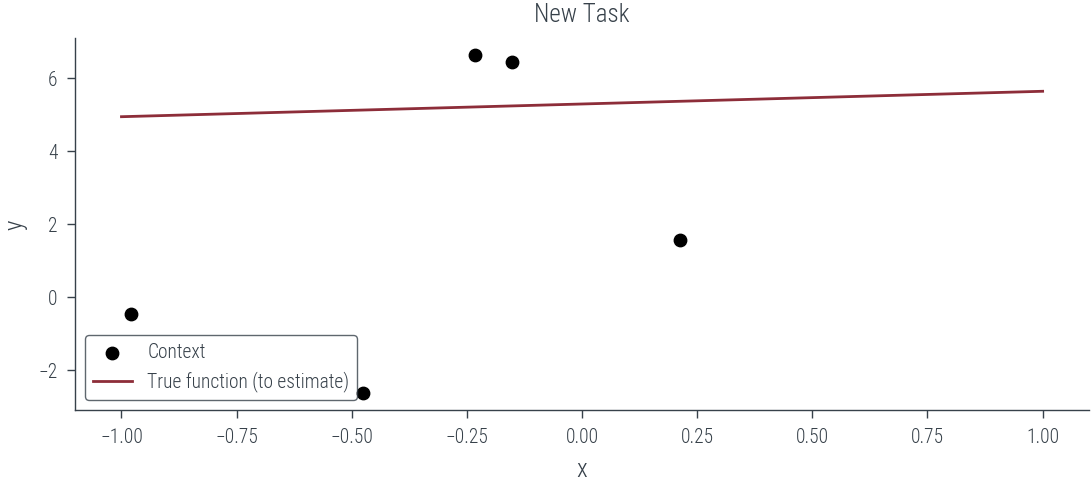

In [59]:
# Plot the last task with few data points (context)
context_size = 5
context_idx = torch.randint(0, 100, (context_size,))
context_x = x_lin[context_idx]
context_y = ys[-1][context_idx]

plt.scatter(context_x, context_y, label='Context', s=20, color='k')
plt.plot(x_lin, true_fs[-1], label='True function (to estimate)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("New Task")
plt.savefig("../diagrams/metalearning/context.pdf", bbox_inches="tight")

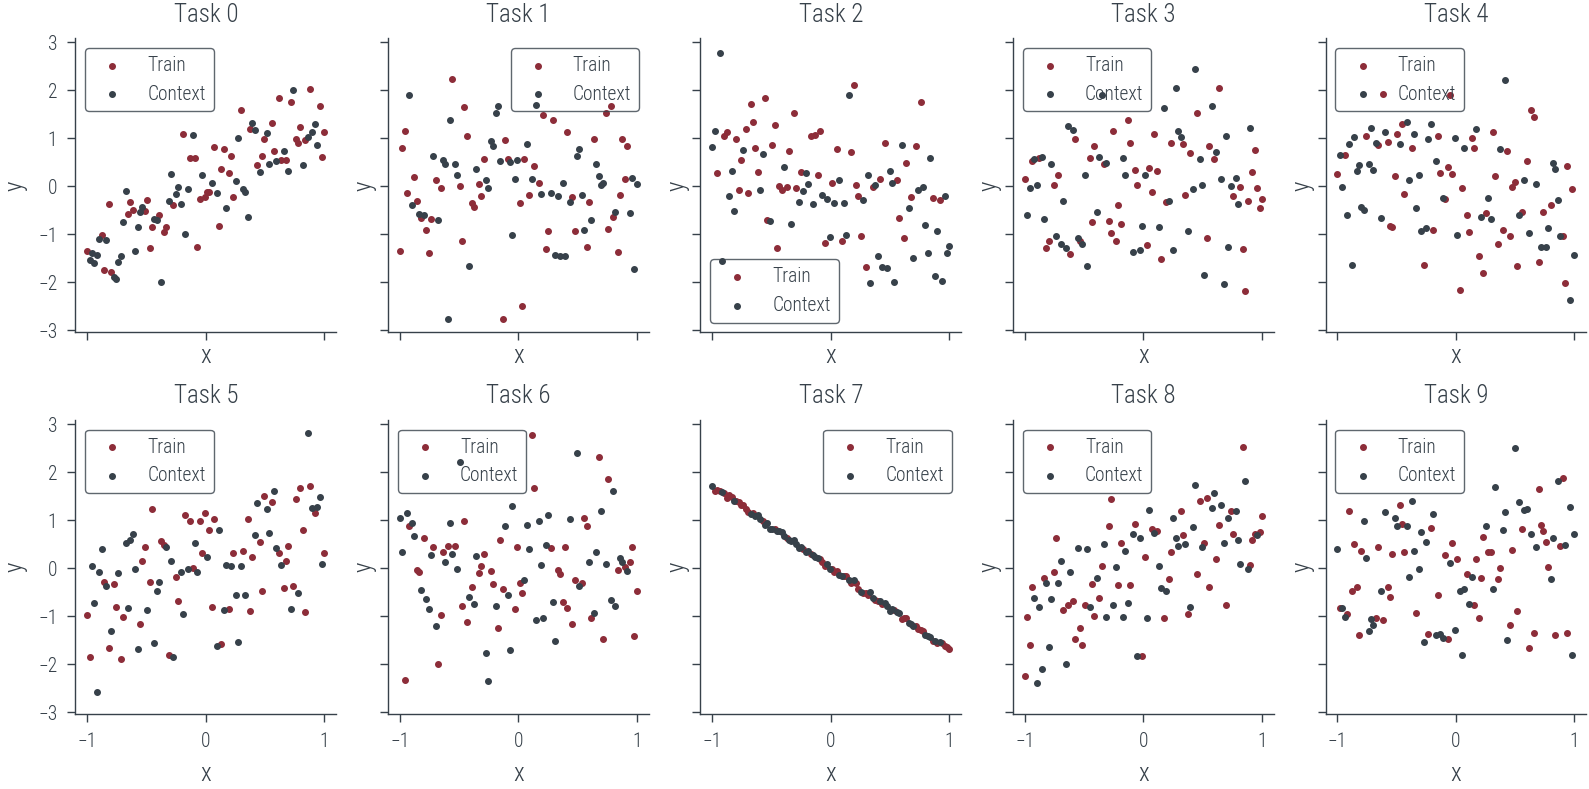

In [61]:
# Split data across each task into train and test sets

x_train = []
y_train = []

x_test = []
y_test = []

for i in range(n_tasks):
    # For each task, divide the data into 50% train and 50% context randomly
    r_perm = torch.randperm(100)
    train_idx = r_perm[:50]
    test_idx = r_perm[50:]
    x_train.append(x_lin[train_idx])
    y_train.append(ys_norm[i][train_idx])
    x_test.append(x_lin[test_idx])
    y_test.append(ys_norm[i][test_idx])
    
    
# Plot the train and test sets for each task

fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.scatter(x_train[i], y_train[i], label='Train', s=4)
    ax.scatter(x_test[i], y_test[i], label='Context', s=4)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Task {i}')
    ax.legend()
    

![](../diagrams/hypernetwork.png)

In [46]:
# Define the hyper-net and target-net
hyper_net = torch.nn.Linear(2, 2)
target_net = torch.nn.Linear(1, 1)

In [47]:
# Let us pick Task 0

task = 0
len_train = len(x_train[task])
x_train_task = x_train[task]
y_train_task = y_train[task]

# Context is 50% of the training data, last 50% is training data
x_c = x_train_task[:len_train // 2]
y_c = y_train_task[:len_train // 2]

x_t = x_train_task[len_train // 2:]
y_t = y_train_task[len_train // 2:]

# Concatenate x_c and y_c to form the context
context = torch.cat([x_c.view(-1, 1), y_c.view(-1, 1)], dim=1)

print(context.shape, x_t.shape, y_t.shape)

torch.Size([40, 2]) torch.Size([40]) torch.Size([40])


In [48]:
# Pass the context to the hyper-net to get output
hyper_out = hyper_net(context)

In [49]:
hyper_out.shape

torch.Size([40, 2])

In [50]:
# Average the output of the hyper-net to get the weights of the target-net
weights = hyper_out.mean(dim=0)
weights.shape

torch.Size([2])

In [51]:
# Create a new target-net with the weight and bias from the hyper-net
target_net_new = torch.nn.Linear(1, 1)
print(target_net_new.weight.data, target_net_new.bias.data)
print(target_net_new.state_dict())

# Set the weights and bias of the new target-net from the hyper-net
target_net_new.weight.data = weights[:1].view(1, 1)
target_net_new.bias.data = weights[1:]

print(target_net_new.weight.data, target_net_new.bias.data)
print(target_net_new.state_dict())

# Create torch.func.functional_call to call the target-net with the 
# weights and bias from the hyper-net
# and pass the test data to get the predictions

target_net_new = torch.nn.Linear(1, 1)
new_dict = target_net_new.state_dict()
new_dict.update({'weight': weights[:1].view(1, 1), 'bias': weights[1:]})
target_net_new.load_state_dict(new_dict)

print(target_net_new.weight.data, target_net_new.bias.data)
print(target_net_new.state_dict())


tensor([[-0.0778]]) tensor([0.7924])
OrderedDict([('weight', tensor([[-0.0778]])), ('bias', tensor([0.7924]))])
tensor([[0.1655]]) tensor([-0.6436])
OrderedDict([('weight', tensor([[0.1655]])), ('bias', tensor([-0.6436]))])
tensor([[0.1655]]) tensor([-0.6436])
OrderedDict([('weight', tensor([[0.1655]])), ('bias', tensor([-0.6436]))])


In [52]:
# Predict on the train set with the new target-net
y_pred = target_net_new(x_t.view(-1, 1)).ravel()

criterion = torch.nn.MSELoss()

l = criterion(y_pred, y_t)
print(l)

tensor(25.3587, grad_fn=<MseLossBackward0>)


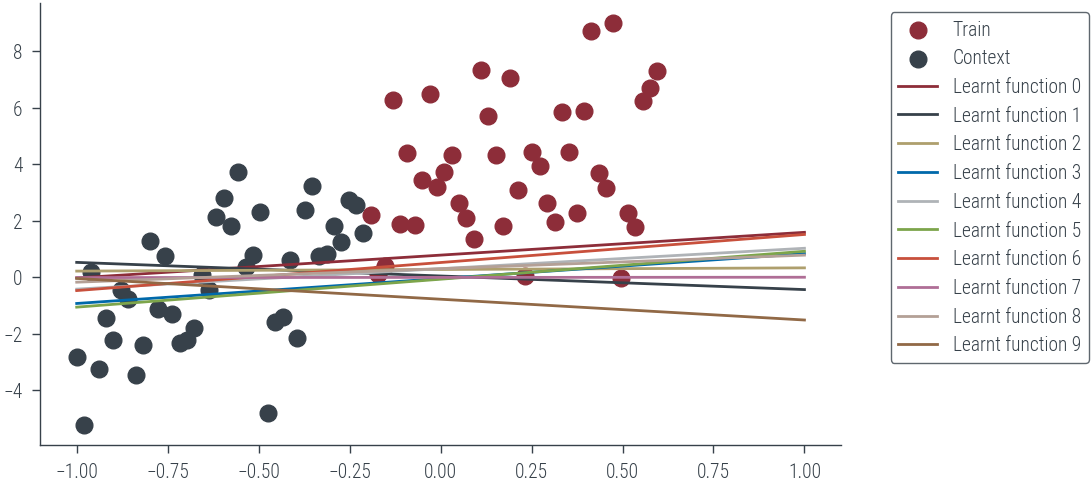

In [53]:
plt.scatter(x_t, y_t, label='Train')
plt.scatter(x_c, y_c, label='Context')
for i in range(10):
    # Define hyper_net and target_net architectures
    hyper_net = torch.nn.Linear(2, 2)
    target_net = torch.nn.Linear(1, 1)  # Create a target_net
   
    # Learnt function 
    with torch.no_grad():
        plt.plot(x_lin, target_net(x_lin.view(-1, 1)).ravel(), label=f'Learnt function {i}')
    # Put legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [54]:
# Define hyper_net and target_net architectures
hyper_net = torch.nn.Linear(2, 2)
target_net = torch.nn.Linear(1, 1)  # Create a target_net

optimizer = torch.optim.Adam(hyper_net.parameters(), lr=0.01)
criterion = nn.MSELoss()
new_dict = target_net.state_dict()


for epoch in range(1000):
    optimizer.zero_grad()

    hyper_out = hyper_net(context)
    weights = hyper_out.mean(dim=0)
    new_dict.update({'weight': weights[:1].view(1, 1), 'bias': weights[1:]})
    #target_net.load_state_dict(new_dict)

    y_pred = torch.func.functional_call(target_net, new_dict, x_t.view(-1, 1)).ravel()

    l = criterion(y_pred, y_t)
    l.backward()
    optimizer.step()

    if epoch % 30 == 0:
        print(f'Epoch {epoch} loss {l:.2f}')


Epoch 0 loss 16.28
Epoch 30 loss 12.37
Epoch 60 loss 9.52
Epoch 90 loss 7.63
Epoch 120 loss 6.44
Epoch 150 loss 5.75
Epoch 180 loss 5.38
Epoch 210 loss 5.19
Epoch 240 loss 5.11
Epoch 270 loss 5.07
Epoch 300 loss 5.06
Epoch 330 loss 5.05
Epoch 360 loss 5.05
Epoch 390 loss 5.05
Epoch 420 loss 5.05
Epoch 450 loss 5.05
Epoch 480 loss 5.05
Epoch 510 loss 5.05
Epoch 540 loss 5.05
Epoch 570 loss 5.05
Epoch 600 loss 5.05
Epoch 630 loss 5.05
Epoch 660 loss 5.05
Epoch 690 loss 5.05
Epoch 720 loss 5.05
Epoch 750 loss 5.05
Epoch 780 loss 5.05
Epoch 810 loss 5.05
Epoch 840 loss 5.05
Epoch 870 loss 5.05
Epoch 900 loss 5.05
Epoch 930 loss 5.05
Epoch 960 loss 5.05
Epoch 990 loss 5.05


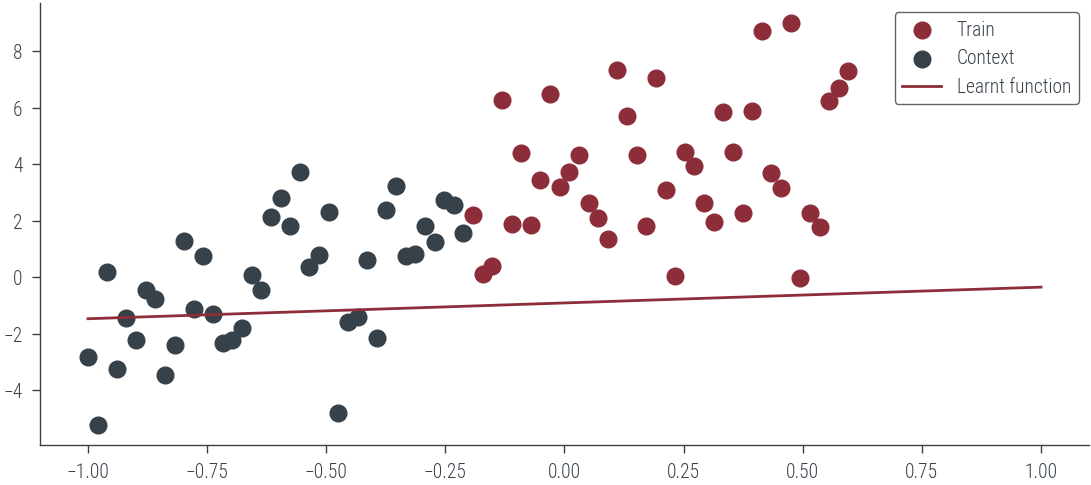

In [55]:
plt.scatter(x_t, y_t, label='Train')
plt.scatter(x_c, y_c, label='Context')
# Learnt function 
with torch.no_grad():
    plt.plot(x_lin, target_net(x_lin.view(-1, 1)).ravel(), label='Learnt function')
plt.legend()
